[View in Colaboratory](https://colab.research.google.com/github/xinliupitt/Projects/blob/master/0426_House_V4_me.ipynb)

# 1. Methodology and Settings (Author: Xin Liu)

## a. Validation Settings
We use 10-fold cross validation for tuning the parameters based on the training dataset.

## b. Performance Measure
The performance measure is Root Mean Squared Logarithmic Error (RMSLE). More specifically, we transform the dependent variable into logarithm scale to achieve the ditribution as normal as possible. Then we use the log form for cross validation in the training set using Root Mean Squared Error. We do the same thing for test set for generating prediction results. Before submitting the prediction results to Kaggle, we transform them using exponential function to the normal scale of house prices.

## c. Baseline Models
XGBRegressor is our baseline model (it is very powerful for Kaggle competitions), which will be elaborated in the next section. We also try different models, i.e., linear regression, Ridge regression, LASSO, random forest regressor, extra trees regressor. 

### Details of the methods and settings in this section will be provided in the next section as we describe the steps of our model.

# 2. Prediction Results

In this section, for feature selection, we try model free and model based methods. The model free method is elaborated in Subsection a(1), and the model based method is elaborated in Subsection a(2).

## Feature Selection -  Model Free

In [0]:
import numpy as np # https://docs.scipy.org/doc/numpy/reference/
import pandas as pd # https://pandas.pydata.org/pandas-docs/stable/
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
import seaborn as sns
import math

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'1vghYJblRUxy5dtuGjBhfULjzorpeRz2A' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: 0420_V2_House.ipynb, id: 1X4V7GITHWVERwpUDGLQrmrXWBkCFohSX
title: train_test.csv, id: 1uKeiBHAkHNJRtG7Kt8VK2GQ5kKdoUn1J
title: 0420_House.ipynb, id: 1_J9l2jGIrQf6A8_nJLKr2saHkFG3zL5G
title: 0417_House.ipynb, id: 19QZbIhaq6emuP6XrHWP8-dFCv04El5ej
title: 0416_2.ipynb, id: 1uAv0YKNDu0rZSkIy0yJuqgM-9TqgQeJo
title: 0416.ipynb, id: 1UKDd_j4f32FNN7cWf35XbevgsxeW8aav
title: 0415_Corrected_2.ipynb, id: 1Z9G5NalmB3KyEFnqV69T0qGyyPyxBARd
title: 0415.ipynb, id: 1PSvyfaVn00nx3Zc0hc4f0HdbqLMrpFPc
title: 0415_Corrected.ipynb, id: 1_cq7xdviFTDN05S0WvPLYPs_9KvgW2I5
title: 0414_House.ipynb, id: 1nqqlpVU2DtHOBDP24Hb51R0UBI4p9qRk
title: train.csv, id: 14TDFgAbfmwr5PcvhiZM1vTnB2xLwszxM
title: test.csv, id: 1ltkGSVLvUKXB3TjzjGCwbWQukz4hu6Ve
title: 0413.ipynb, id: 1CgQv2RAhHE6dMrBdWbwPgOKgZR8QQYHl
title: movie_metadata.csv, id: 1rX03SO_GIxPSLDbIole671LBYne3sp0g
title: IMDB_0411.ipynb, id: 1d02DJ1KMEvhNobQXTbI-5HvEJ3PC7r5T
title: IMDB_0328.ipynb, id: 1URA1g7B7n_sXWQg5_Wj52A9_geaDEi9K


In [0]:
train_downloaded = drive.CreateFile({'id': '1uKeiBHAkHNJRtG7Kt8VK2GQ5kKdoUn1J'})
train_downloaded.GetContentFile('train_test.csv')
# test_downloaded = drive.CreateFile({'id': '1ltkGSVLvUKXB3TjzjGCwbWQukz4hu6Ve'})
# test_downloaded.GetContentFile('test.csv')

In [0]:
train=pd.read_csv('train_test.csv')
train.drop(["Id"], inplace=True, axis=1)

In [0]:
na_count = train.isnull().sum().sort_values(ascending=False)
na_rate = na_count / len(train)
na_data = pd.concat([na_count,na_rate],axis=1,keys=['count','ratio'])
na_data.head(20)

,count,ratio
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageYrBlt,159,0.054471
GarageQual,159,0.054471


In [0]:
train.drop(["PoolQC","GarageQual"], inplace=True, axis=1)

values = {'LotFrontage': 0,'Electrical': "SBrkr",'MasVnrArea': 0}
train=train.fillna(value=values)


Many missing values are actually meaningful. For example, a missing value in "LotFrontage" means this house does not have LotFrontage, such that we can fill this missing area with 0. Additionally, missing values in "Electrical" are treated in a different way since "Electrical" is a categorical variable. Here, we use "most_frequent" principle to fill out the missing values; that is, since the value "SBrkr" appears the most frequently in this categorical variable, we use this value to fill out the missing areas.

In [0]:
imp_list=['GarageYrBlt']
from sklearn.preprocessing import Imputer 
imp=Imputer(missing_values="NaN", strategy="mean",axis=0) # here the strategy is subject to change.
train[imp_list]=imp.fit_transform(train[imp_list])

In [0]:
train.MiscFeature.unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [0]:
# Should convert: MiscFeature to 'Shed'->num
# drop: GarageCond_nan, GarageFinish_nan, BsmtExposure_nan, BsmtQual_nan, BsmtCond_nan, BsmtFinType1_nan, MasVnrType_nan

In [0]:
train['Shed']=train['MiscVal']
for i, content in enumerate(train.loc[:,'MiscFeature']):
  if content=="Shed":
    train.loc[i,'Shed']=train.loc[i,'MiscVal']
  else:
    train.loc[i,'Shed']=0

### Here, we transform two variables 'MiscFeature' and 'MiscVal' since 'MiscFeature' have too many missing values. The most frequent value in 'MiscFeature' is "Shed". Additionally, if 'MiscFeature' is "Shed", 'MiscVal' is a non-zero value. Thus, our idea is to create a new column named "Shed". If this tuple's 'MiscFeature' is "Shed", then we put this tuple's 'MiscVal' in the "Shed" column; otherwise it is zero. For other values in 'MiscFeature', i.e., 'Gar2', 'Othr', 'TenC', they are too few such that we just ignore them.

In [0]:
train.drop(["MiscFeature","MiscVal"], inplace=True, axis=1)

In [0]:
na_count = train[train._get_numeric_data().columns.values.tolist()].isnull().sum().sort_values(ascending=False)
na_rate = na_count / len(train)
na_data = pd.concat([na_count,na_rate],axis=1,keys=['count','ratio'])
na_data.head(10)

,count,ratio
SalePrice,1459,0.499829
BsmtFullBath,2,0.000685
BsmtHalfBath,2,0.000685
BsmtFinSF1,1,0.000343
TotalBsmtSF,1,0.000343
BsmtUnfSF,1,0.000343
BsmtFinSF2,1,0.000343
GarageCars,1,0.000343
GarageArea,1,0.000343
MasVnrArea,0,0.000000


In [0]:
values = {'BsmtFullBath': 0,'BsmtHalfBath': 0,'BsmtFinSF1': 0,'TotalBsmtSF': 0,
          'BsmtUnfSF': 0,'BsmtFinSF2': 0,'GarageCars': 0,'GarageArea': 0}
train=train.fillna(value=values)

In [0]:
font = {'fontname':'Arial', 'size':'14'}
title_font = { 'weight' : 'bold','size':'16'}
plt.hist(train['SalePrice'], bins=20)
plt.title("Distribution of Sale Price")
plt.show()

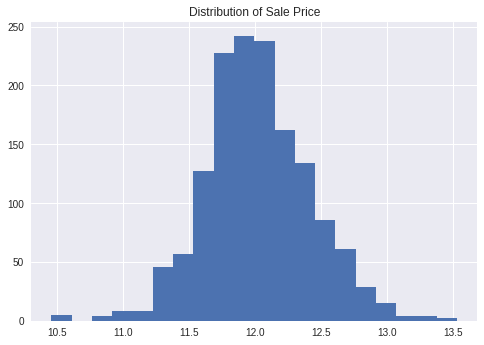

In [0]:
font = {'fontname':'Arial', 'size':'14'}
title_font = { 'weight' : 'bold','size':'16'}
plt.hist(np.log(train['SalePrice']+1), bins=20)
plt.title("Distribution of Sale Price")
plt.show()

In [0]:
labels=np.log(train['SalePrice'][0:1460]+1)
train.drop(["SalePrice"], inplace=True, axis=1)

### The distribution of dependent variable is right skewed. Thus, we should transform it into logarithm scale to achieve the ditribution as normal as possible.

In [0]:
labels

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

In [0]:
numeric_features=train._get_numeric_data().columns.values.tolist()

text_features=train.columns.values.tolist()
text_features=[i for i in text_features if i not in numeric_features]



string_features=[]

categorical_features=[i for i in text_features if i not in string_features]

In [0]:
categorical_features

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'SaleType',
 'SaleCondition']

In [0]:
from sklearn.preprocessing import StandardScaler 
scl=StandardScaler() # do we really need this? Will we try PCA?
train[numeric_features]=scl.fit_transform(train[numeric_features])

### We concatenate the training set and test set together. This is to standardize the numeric values in the training set and test set into the same scope. Thus, the trained model is more reasonably applied to the test set.

In [0]:
train_labels=pd.concat([train[numeric_features][0:1460],labels],axis=1)
train_labels.corr(method='pearson')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,Shed,SalePrice
MSSubClass,1.000000,-0.215023,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.013585,-0.021407,-0.042495,-0.073959
LotFrontage,-0.215023,1.000000,0.100739,0.176561,-0.053457,0.036853,0.078686,0.105010,0.076670,-0.009312,...,-0.016780,0.069605,0.027366,0.023499,0.022969,0.114106,0.018942,-0.012094,-0.026833,0.179303
LotArea,-0.139781,0.100739,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.001205,-0.014261,0.077031,0.257320
OverallQual,0.032628,0.176561,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,0.070815,-0.027347,-0.048262,0.817185
OverallCond,-0.059316,-0.053457,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,-0.003511,0.043950,0.101437,-0.036868
YearBuilt,0.027850,0.036853,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,0.012398,-0.013618,-0.071629,0.586570
YearRemodAdd,0.040581,0.078686,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,0.021490,0.035743,-0.033168,0.565608
MasVnrArea,0.023573,0.105010,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.006723,-0.008317,-0.029482,0.426776
BsmtFinSF1,-0.069836,0.076670,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,-0.015727,0.014359,0.007162,0.372023
BsmtFinSF2,-0.065649,-0.009312,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,-0.015211,0.031706,-0.020337,0.004832


In [0]:
import operator

from scipy.stats import pearsonr
correl={}
for f in numeric_features:
    correl[f]=pearsonr(train[f][0:1460], labels)
sorted_cor = sorted(correl.items(), key=operator.itemgetter(1), reverse=True)
sorted_cor

[('OverallQual', (0.8171846144867664, 0.0)),
 ('GrLivArea', (0.7009269871427148, 3.058151110246981e-216)),
 ('GarageCars', (0.68062487265819, 3.0933822697553465e-199)),
 ('GarageArea', (0.6508876811435945, 1.1060270514515341e-176)),
 ('TotalBsmtSF', (0.6121342283262258, 7.531828096451882e-151)),
 ('1stFlrSF', (0.596981323185534, 1.0742929799898622e-141)),
 ('FullBath', (0.5947706649972536, 2.1186081278426884e-140)),
 ('YearBuilt', (0.5865701927897158, 1.1036359100656293e-135)),
 ('YearRemodAdd', (0.5656077814623206, 3.211680352818505e-124)),
 ('TotRmsAbvGrd', (0.5344224002094415, 1.2925262145272726e-108)),
 ('GarageYrBlt', (0.501656239795724, 6.874994616543787e-94)),
 ('Fireplaces', (0.4894495451574803, 8.420418798327116e-89)),
 ('MasVnrArea', (0.42677555810052514, 1.0775684674920495e-65)),
 ('BsmtFinSF1', (0.3720232531363672, 3.845514461126193e-49)),
 ('WoodDeckSF', (0.3341351729561152, 2.05521204268977e-39)),
 ('OpenPorchSF', (0.321053251590911, 2.3442818185849423e-36)),
 ('2ndFlrSF'

### We sort each numeric variable's correlation to the dependent variable. Here we eliminate 'GarageArea', 'TotalBsmtSF', '1stFlrSF' since they have the similarly large correlation to 'GarageCars'. If we select all of them into the feature set, they may over-dominate the prediction without considering other features. We elimiate 'MoSold' and '3SsnPorch' for similar reasons. Then we also eliminate 'BsmtFinSF2','BsmtHalfBath','LowQualFinSF', 'YrSold', 'Shed' since they are lowly correlated to dependent variable.

In [0]:
#  Deleted:
#  ('GarageArea', (0.6234314389183616, 5.26503816797602e-158)),
#  ('TotalBsmtSF', (0.6135805515591953, 9.484229391503079e-152)),
#  ('1stFlrSF', (0.6058521846919146, 5.394710618968227e-147)),
# ('MoSold', (0.04643224522381935, 0.07612757850604966)),
#  ('3SsnPorch', (0.0445836653357484, 0.0885817035805626)),
#  ('BsmtFinSF2', (-0.01137812145021514, 0.6639986508340475)),
#  ('BsmtHalfBath', (-0.016844154297359016, 0.5201536357277137)),
#  ('LowQualFinSF', (-0.025606130000679534, 0.3282073098405023)),
#  ('YrSold', (-0.028922585168730326, 0.26941319328087404)),
#  ('Shed', (-0.02952721371164022, 0.25952575212142215)),
num_features_2 =['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolArea']

In [0]:
import xgboost as xgb
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = train[num_features_2][0:1460]
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.0, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":np.arange(3,16,2).tolist()}

scores = ['neg_mean_squared_error'] #, 'recall'

mean_list=[]
std_list=[]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(xgb.XGBRegressor(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        mean_list.append(mean)
        std_list.append(std)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'max_depth': 5}

Grid scores on development set:

-0.019 (+/-0.011) for {'max_depth': 3}
-0.019 (+/-0.011) for {'max_depth': 5}
-0.019 (+/-0.012) for {'max_depth': 7}
-0.019 (+/-0.012) for {'max_depth': 9}
-0.020 (+/-0.011) for {'max_depth': 11}
-0.020 (+/-0.010) for {'max_depth': 13}
-0.020 (+/-0.011) for {'max_depth': 15}



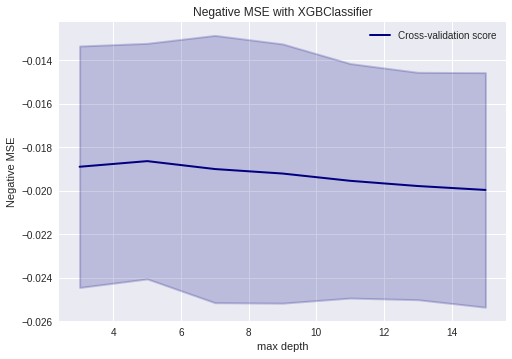

In [0]:
param_range = np.arange(3,16,2)
# param_range = np.logspace(-6, -1, 1)

plt.title("Negative MSE with XGBClassifier")
plt.xlabel("max depth")
plt.ylabel("Negative MSE")
# plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training with cv",
#              color="darkorange", lw=lw)
# plt.plot(param_range, np.asarray(mean_list), label="Training with cv",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, np.asarray(mean_list), label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, np.asarray(mean_list) - np.asarray(std_list),
                 np.asarray(mean_list) + np.asarray(std_list), alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### We only use the numeric variable and the Kaggle score is 0.14061.

In [0]:
for feat in categorical_features:
    train=pd.concat([train, pd.get_dummies(train[feat], prefix=feat, dummy_na=True)],axis=1)

In [0]:
cat_dummies=[i for i in train.columns.values.tolist() if i not in numeric_features]
cat_dummies=[i for i in cat_dummies if i not in text_features]

In [0]:
cat_dummies = [e for e in cat_dummies if e not in ('GarageCond_nan', 'GarageFinish_nan', 'BsmtExposure_nan', 'BsmtQual_nan', 'BsmtCond_nan', 'BsmtFinType1_nan', 'MasVnrType_nan')]

In [0]:
cat_dummies

['MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'MSZoning_nan',
 'Street_Grvl',
 'Street_Pave',
 'Street_nan',
 'Alley_Grvl',
 'Alley_Pave',
 'Alley_nan',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LotShape_nan',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LandContour_nan',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'Utilities_nan',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LotConfig_nan',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'LandSlope_nan',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 '

In [0]:
na_count = train[cat_dummies].isnull().sum().sort_values(ascending=False)
na_rate = na_count / len(train)
na_data = pd.concat([na_count,na_rate],axis=1,keys=['count','ratio'])
na_data.head(20)

,count,ratio
SaleCondition_nan,0,0.0
HouseStyle_SFoyer,0,0.0
HouseStyle_1.5Fin,0,0.0
HouseStyle_1.5Unf,0,0.0
HouseStyle_1Story,0,0.0
HouseStyle_2.5Fin,0,0.0
HouseStyle_2.5Unf,0,0.0
HouseStyle_2Story,0,0.0
HouseStyle_SLvl,0,0.0
Exterior2nd_MetalSd,0,0.0


In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
test = SelectKBest(score_func=f_regression, k=14)
fit = test.fit(train[numeric_features+cat_dummies][0:1460], labels)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [0]:
sorted(fit.scores_.tolist(),reverse=True)

[2930.799393462376,
 1408.1216941511343,
 1258.3494927081047,
 1071.7337999383196,
 873.711793793832,
 807.3354126248678,
 798.100327963809,
 764.779834948932,
 685.8407210074067,
 582.8943201221304,
 490.309616517781,
 459.3131918705752,
 324.69547841381535,
 234.20311205119742,
 205.9374192609456,
 200.17239362631616,
 183.23819449349097,
 167.55432108125152,
 165.52228334405305,
 159.45670595218814,
 142.99878200614765,
 121.66448372926729,
 103.38494285674632,
 86.16740430708151,
 83.74750296505864,
 83.12314828975174,
 75.57038154745312,
 68.40390995407441,
 66.62481917324934,
 53.64168771779892,
 52.00380168166083,
 48.43118059529142,
 43.75583016782891,
 41.70378876029795,
 33.27270600889915,
 33.126828759136444,
 32.447731040643724,
 28.701988858135447,
 21.73926307960091,
 8.019062908169692,
 7.658168174094187,
 7.137779404145439,
 4.807769457710613,
 4.407743886117532,
 2.104263007050543,
 2.027283611078056,
 1.9845319913269925,
 0.9446853023797835,
 0.03865945018696384,
 nan

### Typically, there are two feature selection approaches in this situation. One is model free approach, where a function selects several important features, regardless of the type of model to be used. Another one is model based approach, where the important features are selected based on the type of model to be used.

### Here, we try the model free feature selection and try model based afterwards. It is achieved by "SelectKBest" function in Python. The principle is that "SelectKBest" function wil calculate the f_regression statistic (score) between each feature and the dependent variable. Then we sort the scores. It is noted that some variables have the score nan, which interrupts the sort function in Python. Thus, we elimiate these variables first then sort the scores.

In [0]:
filter_nan_list=[True] *train[numeric_features+cat_dummies].shape[1]

In [0]:
for num in list_nan:
  filter_nan_list[num[0]]=False

In [0]:
filter_nan_array=np.asarray(filter_nan_list)

In [0]:
# def is_nan(x):
#     return (x is np.nan or x != x)

# list_ = fit.scores_.tolist()
# sorted(list_, key = lambda x : float('-inf') if is_nan(x) else x, reverse=True)

In [0]:
# mov_sel_num = fit.transform(train[numeric_features+cat_dummies])
# summarize selected features
feature_names = list(train[numeric_features+cat_dummies].columns.values)

mask = filter_nan_array #list of booleans
new_features_no_nan = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features_no_nan.append(feature)
        
# train_sel = pd.DataFrame(mov_sel_num, columns=new_features)

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
test = SelectKBest(score_func=f_regression, k=15)
fit = test.fit(train[new_features_no_nan][0:1460], labels)

In [0]:
sorted(fit.scores_.tolist(),reverse=True)

[2930.799393462376,
 1408.1216941511343,
 1258.3494927081047,
 1071.7337999383196,
 873.711793793832,
 807.3354126248678,
 802.7287168450205,
 798.100327963809,
 764.779834948932,
 685.8407210074067,
 594.6525692961427,
 582.8943201221304,
 572.0504989478889,
 512.6062140708239,
 511.6544114309268,
 490.309616517781,
 459.3131918705752,
 430.8759111497767,
 406.00772201532317,
 400.0063966256181,
 351.54476969838794,
 334.55081644481595,
 324.69547841381535,
 310.26184987434306,
 304.74033819591796,
 301.4750573070075,
 288.78690708059054,
 270.1695557555557,
 259.3945189283942,
 234.20311205119742,
 225.20826295238393,
 211.7805154730968,
 205.9374192609456,
 205.66600758877598,
 205.66600758875413,
 200.17239362631616,
 197.4333483270136,
 187.81911773155633,
 187.35352340025526,
 185.72250153618683,
 184.840691524886,
 183.48067099764125,
 183.23819449349097,
 177.20005403075626,
 171.56308567782636,
 169.82746929230584,
 167.55432108125152,
 165.52228334405305,
 159.45670595218814,

### According to the sorted score, we select the variables with scores over 500. There are totally 15 selected parameters.

In [0]:
mov_sel_num = fit.transform(train[new_features_no_nan])
# summarize selected features
feature_names = list(train[new_features_no_nan].columns.values)

mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
train_sel = pd.DataFrame(mov_sel_num, columns=new_features)

In [0]:
new_features

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'ExterQual_Gd',
 'ExterQual_TA',
 'Foundation_PConc',
 'KitchenQual_TA',
 'FireplaceQu_nan']

In [0]:
import xgboost as xgb
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = train_sel[0:1460]
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.0, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":np.arange(3,16,2).tolist()}

scores = ['neg_mean_squared_error'] #, 'recall'

mean_list=[]
std_list=[]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(xgb.XGBRegressor(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        mean_list.append(mean)
        std_list.append(std)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

-0.023 (+/-0.013) for {'max_depth': 3}
-0.024 (+/-0.011) for {'max_depth': 5}
-0.024 (+/-0.011) for {'max_depth': 7}
-0.024 (+/-0.011) for {'max_depth': 9}
-0.025 (+/-0.012) for {'max_depth': 11}
-0.025 (+/-0.012) for {'max_depth': 13}
-0.026 (+/-0.013) for {'max_depth': 15}



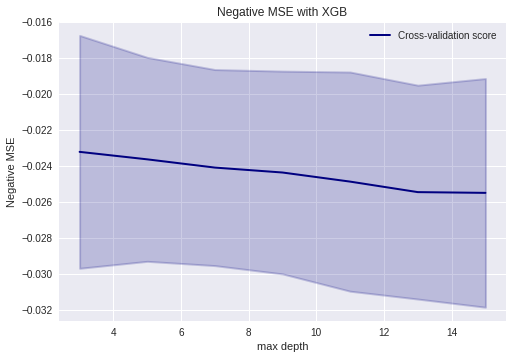

In [0]:
param_range = np.arange(3,16,2)
# param_range = np.logspace(-6, -1, 1)

plt.title("Negative MSE with XGB")
plt.xlabel("max depth")
plt.ylabel("Negative MSE")
# plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training with cv",
#              color="darkorange", lw=lw)
# plt.plot(param_range, np.asarray(mean_list), label="Training with cv",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, np.asarray(mean_list), label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, np.asarray(mean_list) - np.asarray(std_list),
                 np.asarray(mean_list) + np.asarray(std_list), alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [0]:
test=train_sel[1460:2919]

In [0]:
clf = xgb.XGBRegressor(max_depth=3)
clf.fit(train[new_features][0:1460], labels)
y_pred = clf.predict(test)

In [0]:
np_array=np.exp(y_pred)-1
np_array_list=np_array.tolist()

### We also try PCA.

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=39)
pca.fit(train[numeric_features+cat_dummies][0:1460])

PCA(copy=True, iterated_power='auto', n_components=39, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
sum(pca.explained_variance_ratio_)

0.8521135413781512

### We also try PCA. We use 39 components to explain over 85% of the variation.

In [0]:
train_pca = pca.fit_transform(train[numeric_features+cat_dummies][0:1460])

In [0]:
train_pca_Df = pd.DataFrame(data = train_pca)

In [0]:
import xgboost as xgb
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = train_pca_Df
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.0, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":np.arange(3,16,2).tolist()}

scores = ['neg_mean_squared_error'] #, 'recall'

mean_list=[]
std_list=[]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(xgb.XGBRegressor(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        mean_list.append(mean)
        std_list.append(std)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for neg_mean_squared_error

Best parameters set found on development set:

{'max_depth': 5}

Grid scores on development set:

-0.018 (+/-0.012) for {'max_depth': 3}
-0.018 (+/-0.010) for {'max_depth': 5}
-0.019 (+/-0.011) for {'max_depth': 7}
-0.019 (+/-0.011) for {'max_depth': 9}
-0.019 (+/-0.010) for {'max_depth': 11}
-0.019 (+/-0.011) for {'max_depth': 13}
-0.020 (+/-0.011) for {'max_depth': 15}



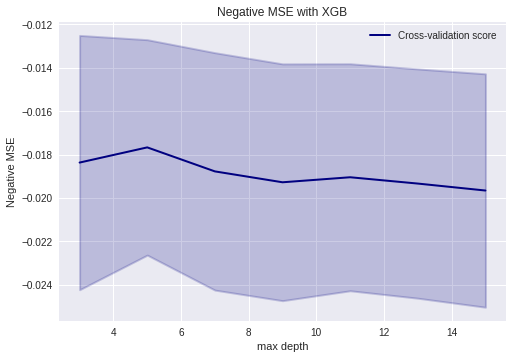

In [0]:
param_range = np.arange(3,16,2)
# param_range = np.logspace(-6, -1, 1)

plt.title("Negative MSE with XGB")
plt.xlabel("max depth")
plt.ylabel("Negative MSE")
# plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training with cv",
#              color="darkorange", lw=lw)
# plt.plot(param_range, np.asarray(mean_list), label="Training with cv",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, np.asarray(mean_list), label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, np.asarray(mean_list) - np.asarray(std_list),
                 np.asarray(mean_list) + np.asarray(std_list), alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Here the Kaggle RMSLE is 0.1406